In [2]:
import numpy as np 
import torch
import matplotlib.pyplot as plt
import os
import copy
import glob
import obspy

from util import HNO, process, fwi_wrap, figplot
from util.process import InputNormalizer, OutputNormalizer
from joblib import load
from obspy.geodetics.base import gps2dist_azimuth
from torch.nn import DataParallel
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
from scipy.interpolate import interp1d 

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1, 3"
device = torch.device('cuda')
device_ids = [0, 1]

In [ ]:
eps = 0
start_time_in_seconds = -4  # training actually starts from 0 s
end_time_in_seconds = 40
time_step_in_seconds = 1e-3
sampling_interval_in_time_steps = 100
dt = time_step_in_seconds * sampling_interval_in_time_steps
i0 = round(-start_time_in_seconds / dt)
tau_sim = np.arange(round(end_time_in_seconds/dt)+1) * dt

fs = 1 / dt
fn = fs / 2  # Nyquist frequency
T = round((end_time_in_seconds - start_time_in_seconds) / dt + 1)
pad = 0
nt = T - i0 + 2 * pad
if nt % 2 == 0:
    NT = nt
else:
    NT = nt + 1

freqs = torch.arange(NT // 2 + 1) * fs / (NT - 1)
freqmin = 0.2
freqmax = 0.5
freq_to_keep = torch.where((freqs>=freqmin)&(freqs<=freqmax))[0].tolist()
NF = len(freq_to_keep)

xrange = 80700.414
yrange = 40000
nx, ny = 256, 128
dx = xrange / (nx-1)
dy = yrange / (ny-1)
xcoor, ycoor = torch.linspace(0, xrange, nx), torch.linspace(0, yrange, ny)
xx, yy = torch.meshgrid(xcoor, ycoor, indexing='ij')
src_width_x, src_width_y = 160, 160  # in m, very sensitive

in_channels = 4
out_channels = 4
width = 32
d_pe = 2

batch_size = 64

tau_len_data = 100  # correlation shifting length - investigation depth
sampling_rate_data = 50  # resampling rate of data
dt_data = 1 / sampling_rate_data
shift_data = round(tau_len_data/dt_data)
tau_data = np.arange(shift_data+1) * dt_data

lr = 0.05
milestones = [5, 10, 15]
gamma = 0.5

offsetmin = 5000  # > 
offsetmax = xrange  # <=

coef = 1  # coefficient of Lp prior, not very important
p = 20  # p of Lp prior, not very important

nstage = 4  # number of training stages from lower to higher frequencies
nepoch = 20
nf_per_stage = [NF // nstage for _ in range(nstage)]
nf_per_stage[-1] += NF % nstage
nepoch_per_stage = [nepoch // nstage for _ in range(nstage)]
nepoch_per_stage[-1] += nepoch % nstage
assert np.sum(nepoch_per_stage) == nepoch

vsmean = 2650
vsstd = 2350
vpmean = 5000
vpstd = 4000

sigma_vs = 3
sigma_vp = 3
weight_decay = 0
lam_vpvs = 6e-7
adameps = 1e-4

In [4]:
model = HNO.UNO2D(in_channels, out_channels, width, pad=0, d_pe=d_pe)
model.to(device)
model = DataParallel(model, device_ids=device_ids)
model.load_state_dict(torch.load("../model/HNO.pth"))

x_standardizer = load("../model/x_normalizer.sav")
y_standardizer = load("../model/y_normalizer.sav")

In [5]:
# load nodal data
data_path = "/net/sb/data1/BASIN/SB1/TIMEdir50/"  # change it to your data path 

all = glob.glob(data_path+"*/*.*.BHZ.sac")
period = list(set([one[34:44] for one in all]))
period = process.sort_datetime(period)
        
all_data = glob.glob(data_path+"{}/{}0000.*.BHZ.sac".format(period[24*7], period[24*7]))  ##
station_nums = [trace[-12:-8] for trace in all_data]
nsts = len(station_nums)
print("{} stations included".format(nsts))
lats = []
lons = []

for num in station_nums:
    filename = data_path + "{}/{}0000.{}.BHZ.sac".format(period[24*7], period[24*7], num) 
    st = copy.deepcopy(obspy.read(filename)[0])
    lats.append(st.stats.sac.stla)
    lons.append(st.stats.sac.stlo)

station_nums = np.array(station_nums)
lats = torch.from_numpy(np.array(lats))  # (nstations,)
lons = torch.from_numpy(np.array(lons))  # (nstations,)
ref_lat = lats.mean()
# Convert lats and longs to x (km)
xs = torch.zeros_like(lats)
ori = np.argmin(lons)  # from W to E
xs[ori] = 0 
for i in range(xs.size(0)):
    xs[i] = gps2dist_azimuth(ref_lat, lons[i], ref_lat, lons[ori])[0] / 1000

assert xs[ori] == 0 

# rearrange the data following ascending order of x
order = torch.argsort(xs)
xs = xs[order]
lats = lats[order]
lons = lons[order]
station_nums = station_nums[order]

srcxs = xs * 1000
recxs = xs * 1000

234 stations included


In [6]:
CC_ZZ = torch.from_numpy(np.load('../data/CCSB1ZZ.npy'))
CC_ZR = torch.from_numpy(np.load('../data/CCSB1ZR.npy'))
observe = torch.stack([CC_ZR, CC_ZZ], dim=-1)

In [7]:
recidx = []  # receiver indices to evaluate with observations 
for i in range(len(recxs)):
    recidx.append((xcoor-recxs[i]).abs().argmin().item())


In [8]:
a = torch.zeros(nx, ny, 3) 
test_in = torch.zeros(len(srcxs)*NF, nx, ny, in_channels)
test_out = torch.zeros(len(srcxs)*NF, len(recxs), 1, out_channels)
test_srcx = torch.zeros(len(srcxs)*NF, 1)

for i in range(len(srcxs)):
    srcxy = torch.tensor([srcxs[i], 0], dtype=torch.float64)
    test_srcx[i*NF:(i+1)*NF] = srcxy[0]
    a[:, :, 2] = torch.exp(-(xx - srcxy[0]) ** 2 / src_width_x ** 2) * \
        torch.exp(-(yy - srcxy[1]) ** 2 / src_width_y ** 2) 
    u = torch.zeros(len(recxs), 1, nt, out_channels//2)
    for j in range(len(recxs)):
        for k in range(out_channels//2):
            observe[i, j, :, k] = torch.from_numpy(process.spectral_whitening(observe[i, j, :, k], sampling_rate_data, demean=True, whiten=False, freqmin=0.1, freqmax=0.5).copy())
            observe[i, j, :, k] = process.apply_phase_shift(observe[i, j, :, k], shift=-torch.pi/4)
            f = interp1d(tau_data, observe[i, j, :, k], kind='linear')
            u[j, 0, :, k] = torch.from_numpy(f(tau_sim)) 
            
    test_in[i*NF:(i+1)*NF], test_out[i*NF:(i+1)*NF] = process.convert_to_freq_in_and_out(a.unsqueeze(0), u.unsqueeze(0), fs, freqmin, freqmax, pad=pad, taper='cos')

x_standardizer.encode(test_in)

In [9]:
assert not torch.isnan(test_out).any()

In [10]:
test_loaders = []
count = 0
for i in range(nstage):
    sub_test_in = []
    sub_test_out = []
    sub_test_srcx = []
    for j in range(0, count+nf_per_stage[i]):  # the jth frequency component, start from count if not including previous freqs
        sub_test_in.append(test_in[j:j+NF*len(srcxs):NF])
        sub_test_out.append(test_out[j:j+NF*len(srcxs):NF])
        sub_test_srcx.append(test_srcx[j:j+NF*len(srcxs):NF])

    sub_test_in = torch.cat(sub_test_in, 0)
    sub_test_out = torch.cat(sub_test_out, 0)
    sub_test_srcx = torch.cat(sub_test_srcx, 0)
    count += nf_per_stage[i]

    test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(
            sub_test_in,
            sub_test_out, 
            sub_test_srcx),
        batch_size=batch_size,
        shuffle=True)
    
    test_loaders.append(test_loader)

In [11]:
fwi = fwi_wrap.auto_diff_FWI(vs_init=torch.randn(nx, ny), vp_init=torch.randn(nx, ny)).to(device)
fwi.load_state_dict(torch.load("../model/init_1dli_real.pth"))
vp_init = fwi.vp.cpu().detach().numpy()
vs_init = fwi.vs.cpu().detach().numpy()
vp_init = vp_init * (x_standardizer.std[0].item() + x_standardizer.eps) + x_standardizer.mean[0].item()
vs_init = vs_init * (x_standardizer.std[1].item() + x_standardizer.eps) + x_standardizer.mean[1].item()
optimizer = torch.optim.Adam(fwi.parameters(), lr=lr, weight_decay=weight_decay, eps=adameps)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

In [12]:
xrec = xcoor[recidx]

In [13]:
criterion = torch.nn.MSELoss() 
y_standardizer.cuda()

fwi.train()
model.eval()
istage = 0
for i in tqdm(range(nepoch)): 
    if i == np.sum(nepoch_per_stage[:(istage+1)]):
        istage = istage + 1

    for x, y, srcx in test_loaders[istage]:
        optimizer.zero_grad() 
        x, y = x.to(device), y.to(device)
        mask = process.get_mask(srcx.squeeze(), xrec, offsetmin, offsetmax)
        out = fwi(x, model)
        y_standardizer.decode(out) 
        y = y[mask]  # (npoint, 1, 4)
        out = out[:, recidx, :, :][mask] # (npoint, 1, 4)
        out, y = process.one_bit_whiten(out), process.one_bit_whiten(y) # (npoint, 1, 4)
        loss = criterion(out, y)
        loss += process.lp_prior_single(fwi.vp, x_standardizer.mean[0].item(), x_standardizer.std[0].item(), x_standardizer.eps, coef, p, vpmean, vpstd)  # unnecessary
        loss += process.lp_prior_single(fwi.vs, x_standardizer.mean[1].item(), x_standardizer.std[1].item(), x_standardizer.eps, coef, p, vsmean, vsstd)  # unnecessary
        loss += process.vpvsbrocher(fwi.vp * (x_standardizer.std[0].item() + x_standardizer.eps) + x_standardizer.mean[0].item(), 
                                       fwi.vs * (x_standardizer.std[1].item() + x_standardizer.eps) + x_standardizer.mean[1].item(), 
                                       lam_vpvs)
        loss.backward() 

        ## smooth gradient
        fwi.vp.grad = torch.from_numpy(gaussian_filter(fwi.vp.grad.cpu(), sigma=sigma_vp)).to(fwi.vp.grad.device)
        fwi.vs.grad = torch.from_numpy(gaussian_filter(fwi.vs.grad.cpu(), sigma=sigma_vs)).to(fwi.vs.grad.device)
        
        optimizer.step()
    
    scheduler.step()
    

100%|██████████| 20/20 [07:30<00:00, 22.53s/it]


In [14]:
torch.save(fwi.state_dict(), "../model/inv_1dli_real.pth")

In [15]:
vp_inv = fwi.vp.cpu().detach().numpy()
vs_inv = fwi.vs.cpu().detach().numpy()
vp_inv = vp_inv * (x_standardizer.std[0].item() + x_standardizer.eps) + x_standardizer.mean[0].item()
vs_inv = vs_inv * (x_standardizer.std[1].item() + x_standardizer.eps) + x_standardizer.mean[1].item()

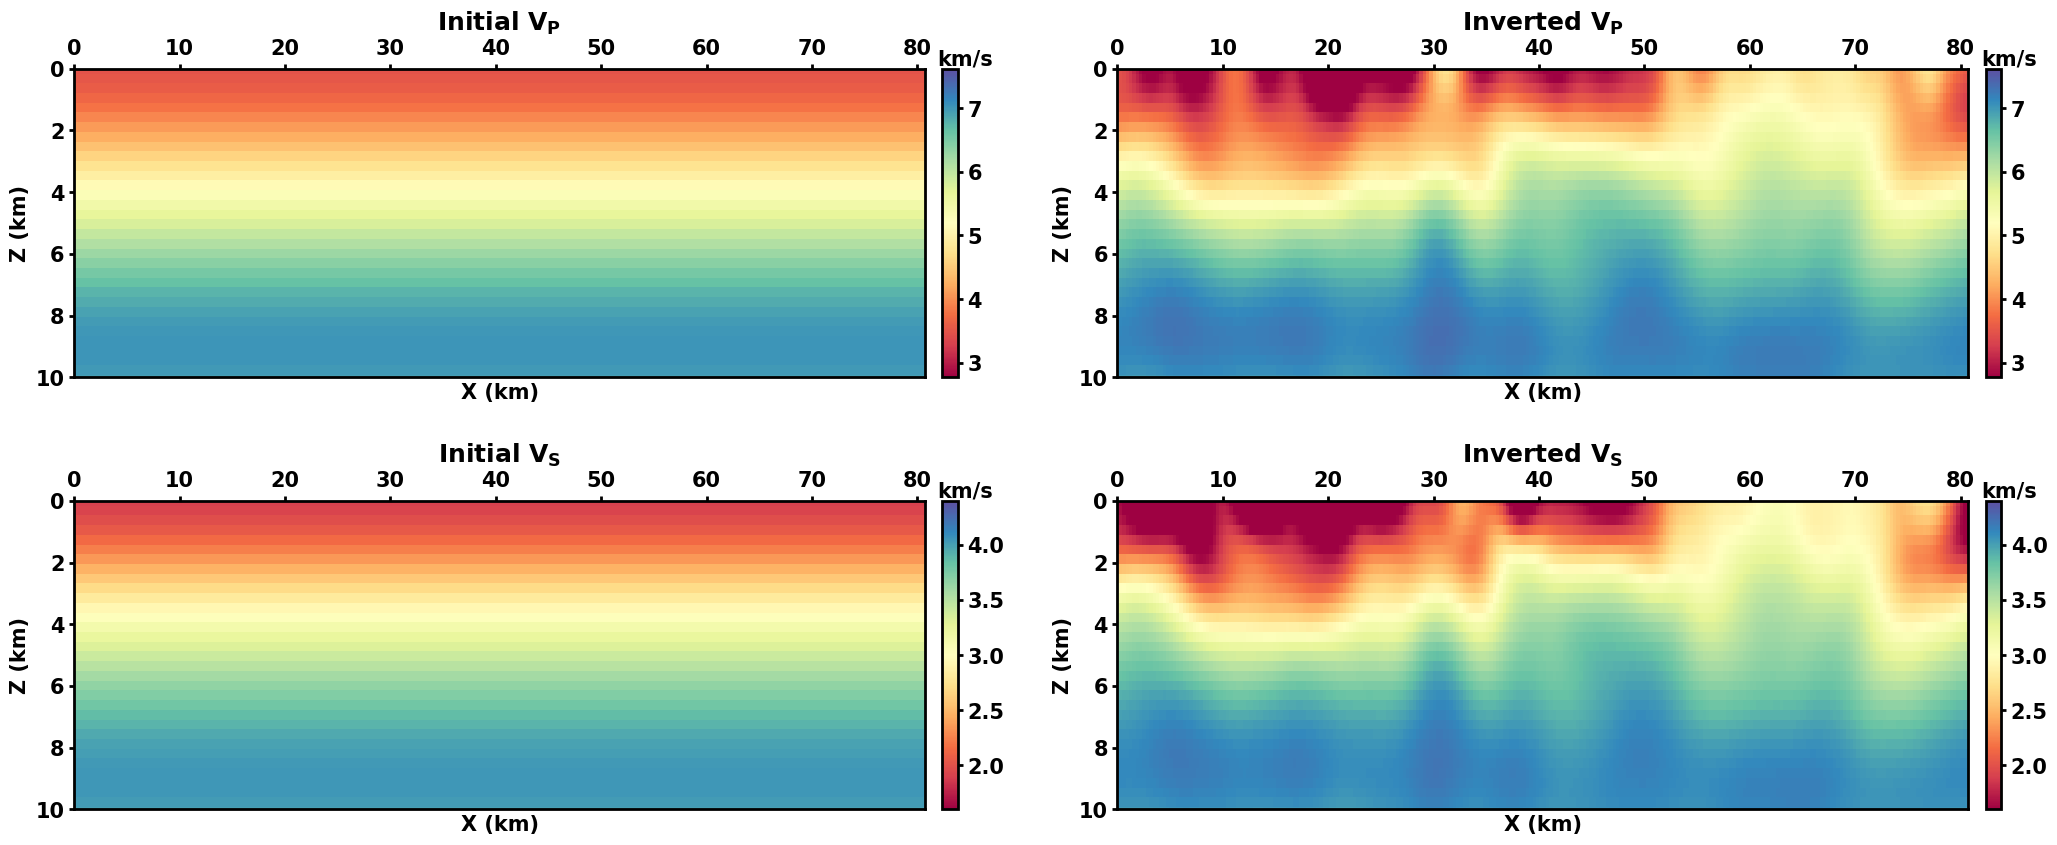

In [16]:
zcut = 10000
jcut = np.argmin(np.abs(ycoor-zcut)) + 1
figplot.plot_fwi_result(vp_init[:, :jcut], vp_inv[:, :jcut], vs_init[:, :jcut], vs_inv[:, :jcut], xrange, ycoor[jcut-1], nx, jcut, y1=10)